# 验证站点数据

# Import packages

In [1]:
# Reading/Writing Data
import os
import glob
import numpy as np
import pandas as pd
import math 
import matplotlib.pyplot as plt

# Pytorch
import torch 
from torch.utils.data import DataLoader, random_split

# Self-Defined Package
from SMAPDataset import SMAPDataset
from SMCNN import SMCNN
from Preprocessing import random_spatial_sequence, collate_insitu_validation

C:\Users\jianer\anaconda3\envs\datamining\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Some Utility Functions

In [3]:
def same_seed(seed): 
    '''Fixes random number generator seeds for reproducibility.'''
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

# Configurations
`config` contains hyper-parameters for training and the path to save your model.

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
config = {
    'seed': 11611801,      # Your seed number, you can pick your lucky number. :)
    'test_ratio': 0.2,
    'valid_ratio': 0.2,   # validation_size = train_size * valid_ratio
    'train_batch_size': 1, 
    'valid_batch_size': 1,
    'test_batch_size': 1,
    'data_loader': 'test',
    'root': 'D:\\1GRADUATED\\paper\\downscaling_data\\Soil_moisture_downscale_czt\\DATASET\\AB',
    'model_save_dir': 'D:\\1GRADUATED\\paper\\downscaling_data\\Soil_moisture_downscale_czt\\DATASET\\AB\\OUTPUT\\MODELS\\CNN_FROM_INSITU'
}

In [5]:
# # Set seed for reproducibility
same_seed(config['seed'])

In [6]:
print(config['root'])
# 创建数据集
insitu_dataset = SMAPDataset(config['root'], insitu_validation=True)
# 创建数据加载器
total_loader = DataLoader(insitu_dataset, batch_size=config['test_batch_size'], shuffle=False, collate_fn=collate_insitu_validation)

D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\AB
***************************Load data path******************************
_______________________________2015104_______________________________
_____________________________smap cell: 15_____________________________
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\AB\INPUT\SMAP\2015104\15.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\AB\INPUT\TEXTURE\15.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\AB\INPUT\NDVI\GRID\2015104\15.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\AB\LABEL\SMAP\2015104\15.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\AB\LABEL\SM\2015104\4.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\AB\LABEL\ATI\INSITU\2015104\4.npy
_____________________________smap cell: 17_____________________________
D:\1GRADUATED\paper\down

D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\AB\LABEL\SM\2015211\33.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\AB\LABEL\ATI\INSITU\2015211\33.npy
_______________________________2015213_______________________________
_____________________________smap cell: 17_____________________________
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\AB\INPUT\SMAP\2015213\17.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\AB\INPUT\TEXTURE\17.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\AB\INPUT\NDVI\GRID\2015213\17.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\AB\LABEL\SMAP\2015213\17.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\AB\LABEL\SM\2015213\18.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\AB\LABEL\ATI\INSITU\2015213\18.npy
_____________________________smap 

D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\AB\LABEL\ATI\INSITU\2015290\4.npy
_____________________________smap cell: 16_____________________________
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\AB\INPUT\SMAP\2015290\16.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\AB\INPUT\TEXTURE\16.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\AB\INPUT\NDVI\GRID\2015290\16.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\AB\LABEL\SMAP\2015290\16.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\AB\LABEL\SM\2015290\1.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\AB\LABEL\ATI\INSITU\2015290\1.npy
_____________________________smap cell: 17_____________________________
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\AB\INPUT\SMAP\2015290\17.npy
D:\1GRADUATED\paper\downscaling_d

In [7]:
print(len(insitu_dataset))

493


In [8]:
# 计算训练集和测试集的长度
train_len = int(len(insitu_dataset) * (1-config['test_ratio']))
test_len = len(insitu_dataset) - train_len

# 使用 random_split 函数进行划分
train_dataset, test_dataset = random_split(insitu_dataset, [train_len, test_len])

# 计算训练集和验证集的长度
valid_len = int(train_len * (config['valid_ratio']))
train_len = train_len - valid_len

# 使用 random_split 函数进行划分
train_dataset, valid_dataset = random_split(train_dataset, [train_len, valid_len])

# 创建数据加载器
train_loader = DataLoader(train_dataset, batch_size=config['train_batch_size'], shuffle=False, collate_fn=collate_insitu_validation)
valid_loader = DataLoader(valid_dataset, batch_size=config['valid_batch_size'], shuffle=False, collate_fn=collate_insitu_validation)
test_loader = DataLoader(test_dataset, batch_size=config['test_batch_size'], shuffle=False, collate_fn=collate_insitu_validation)

print('training size', len(train_dataset))
print('validing size', len(valid_dataset))
print('testing size', len(test_dataset))

training size 316
validing size 78
testing size 99


In [9]:
loaders = {}
loaders['train'] = train_loader
loaders['valid'] = valid_loader
loaders['test'] = test_loader
loaders['total'] = total_loader
data_loader = loaders[config['data_loader']]

In [10]:
import datetime

# The index of day start from 1
# day 从 1 开始
def date2day(date, fm="%Y-%m-%d"):
    date_object = datetime.datetime.strptime(date, fm)
    day_of_year = date_object.timetuple().tm_yday
    return day_of_year

def day2date(year, day):
    date = datetime.datetime(year, 1, 1) + datetime.timedelta(day - 1)
    month = date.month
    day = date.day
    return date

In [11]:
def tester(test_loader, model, config, device):
    relu = torch.nn.ReLU(inplace=True)
#     criterion = ab_physics_loss
    model.eval()
    pred_pkg = {'date':[], 'smapid':[], 'insituid':[], 'a': [], 'b': [], 'smap': [], 'insitu_ati': [], 'insitu_sm':[], 'pred_sm':[]}
    pred_list = np.zeros((len(test_loader), 2))
    for i, data_pkg in enumerate(test_loader):
        x = data_pkg['processed_data']
        with torch.no_grad():
            pred = model(x)
            relu(pred[:, 0])
#             x, pred = x.to(device), pred.to(device)  
        year = 2015
        day = int(data_pkg['meta_data'][0]['date'].split(str(year))[-1])
        date = day2date(year, day)
        smapid = data_pkg['meta_data'][0]['smapid']
        insituid_list = data_pkg['meta_data'][0]['insituid']
        for i in range(len(insituid_list)):
            # 去点站点sm为零的数据
            if(data_pkg['label_data']['insitu_sm'][0][i][0]<=0):
                continue
            if(insituid_list[i]=='16' or insituid_list[i]=='33'):
                continue
            pred_pkg['date'].append(date)
            pred_pkg['smapid'].append(smapid)
            pred_pkg['insituid'].append(insituid_list[i])
            pred_pkg['a'].append(pred[0][0].item())
            pred_pkg['b'].append(pred[0][1].item())
            pred_pkg['smap'].append(data_pkg['label_data']['smap'][0][0].detach().item())
            pred_pkg['insitu_ati'].append(data_pkg['label_data']['insitu_ati'][0][i][0])
            pred_pkg['insitu_sm'].append(data_pkg['label_data']['insitu_sm'][0][i][0])
            pred_sm = pred[0][0].item()*data_pkg['label_data']['insitu_ati'][0][i][0] + pred[0][1].item()
            pred_pkg['pred_sm'].append(pred_sm)
            
    return pred_pkg

In [12]:
param_path = os.path.join(config['model_save_dir'], 'first.ckpt' )
print(insitu_dataset.get_input_shape(0))
model = SMCNN(input_channel=insitu_dataset.get_input_shape(0)[2]).to(device)
print(model)
model.load_state_dict(torch.load(param_path))
pred_pkg = tester(data_loader, model, config, device) 

(11, 11, 20)
SMCNN(
  (cnn): Sequential(
    (0): Conv2d(20, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (fc): Sequential(
    (0): Linear(in_features=3872, out_features=4, bias=True)
    (1): ReLU()
    (2): Linear(in_features=4, out_features=2, bias=True)
  )
)


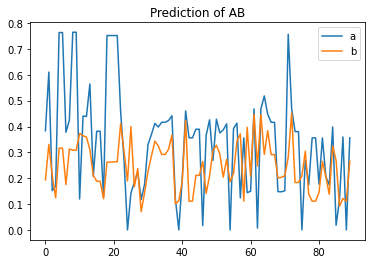

In [13]:
plt.plot(pred_pkg['a'], label='a')
plt.plot(pred_pkg['b'], label='b')
# 添加标题和标签
plt.title('Prediction of AB')
# plt.xlabel('Index of Model')
plt.legend()
plt.show()

In [14]:
df = pd.DataFrame(pred_pkg)
df = df.sort_values(by='date', ascending=True, kind='stable')
df = df.sort_values(by='insituid', ascending=True, kind='stable')
df = df.reset_index(drop=True)
print(df)
df.info()

         date smapid insituid         a         b      smap  insitu_ati  \
0  2015-04-25     16        1  0.425921  0.209122  0.194087    0.046995   
1  2015-04-25     31       10  0.518261  0.292156  0.202477    0.030538   
2  2015-06-11     31       10  0.610470  0.330751  0.219264    0.035714   
3  2015-10-02     31       10  0.564708  0.310919  0.235556    0.032046   
4  2015-06-14     44       11  0.763396  0.316300  0.210138    0.045155   
..        ...    ...      ...       ...       ...       ...         ...   
85 2015-07-21      9       55  0.016876  0.264502  0.199254    0.037467   
86 2015-08-01      9       55  0.018115  0.268760  0.234100    0.062682   
87 2015-08-23      9       55  0.007255  0.247120  0.180653    0.041000   
88 2015-09-24      9       55  0.000000  0.208838  0.202869    0.049770   
89 2015-10-12      9       55  0.000000  0.188964  0.166182    0.038570   

    insitu_sm   pred_sm  
0    0.434795  0.229139  
1    0.357143  0.307983  
2    0.325761  0.3525

In [15]:
import random

start = 0
end = df.shape[0]-1
num_samples = 1

sample = np.random.randint(start, end+1, size=num_samples)
print(sample)

[45]


In [16]:
df.iloc[sample]

,date,smapid,insituid,a,b,smap,insitu_ati,insitu_sm,pred_sm
45,2015-06-11,40,35,0.391858,0.218455,0.236381,0.043095,0.328812,0.235341


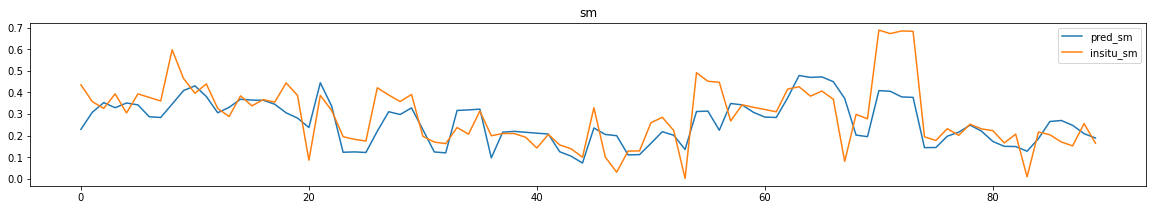

In [17]:
for i in range(int(df.shape[0]/100)+1):
    plt.figure(figsize=(20,3))
    plt.plot(df['pred_sm'].iloc[i*100:(i+1)*100], label='pred_sm')
    plt.plot(df['insitu_sm'].iloc[i*100:(i+1)*100], label='insitu_sm')
    # 添加标题和标签
    plt.title('sm')
    plt.legend()
    plt.savefig(os.path.join(config['model_save_dir'], 'sm for all waternet part '+str(i)), dpi=300, bbox_inches='tight')
    plt.show()

# 总体R和RMSE

In [18]:
corr = df['pred_sm'].corr(df['insitu_sm'])
print(corr)

0.7022317719450778


In [19]:
from sklearn.metrics import mean_squared_error
# calculate the mean squared error (MSE)
mse = mean_squared_error(df['insitu_sm'], df['pred_sm'])

# calculate the root mean squared error (RMSE)
rmse = np.sqrt(mse)
print(rmse)

0.10584190350661303


# 站点R和RMSE

In [20]:
print(df['insituid'])

0      1
1     10
2     10
3     10
4     11
      ..
85    55
86    55
87    55
88    55
89    55
Name: insituid, Length: 90, dtype: object


In [21]:
insitu_grouped = df.groupby(['insituid'])

In [22]:
def calc_rmse(group):
    return np.sqrt(mean_squared_error(group['insitu_sm'], group['pred_sm']))

def calc_corr(group):
    return group.corr().iloc[0, 1]

In [23]:
insitu_rmse = insitu_grouped.apply(calc_rmse)
print(insitu_rmse)

insituid
1     0.205657
10    0.049066
11    0.068141
12    0.133233
18    0.079099
2     0.043610
22    0.061574
25    0.104584
30    0.044212
31    0.079467
32    0.045591
35    0.126699
37    0.017372
4     0.089332
40    0.183078
42    0.042446
5     0.133928
52    0.089524
53    0.289820
54    0.050156
55    0.066288
dtype: float64


(1, 9)
0.20565660552539045


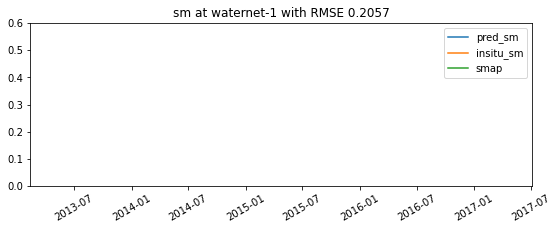

(3, 9)
0.04906589582221471


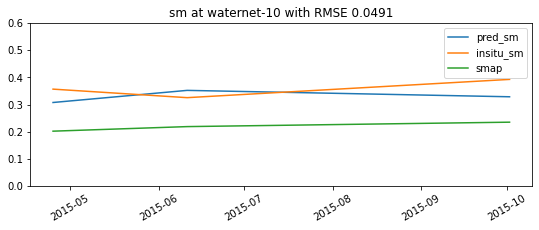

(4, 9)
0.0681412271719527


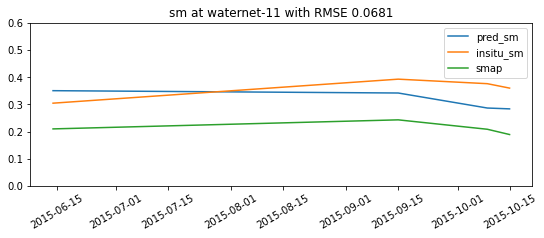

(4, 9)
0.13323317074965935


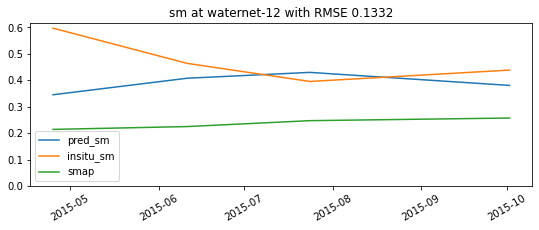

(9, 9)
0.07909898411658649


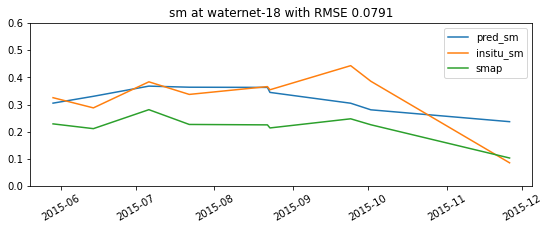

(2, 9)
0.04361036803622112


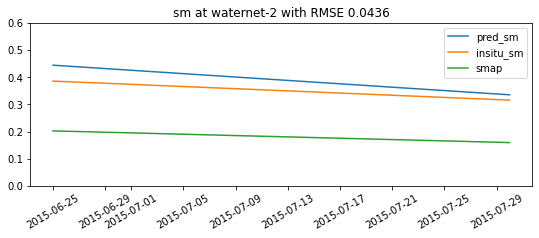

(3, 9)
0.06157380324927009


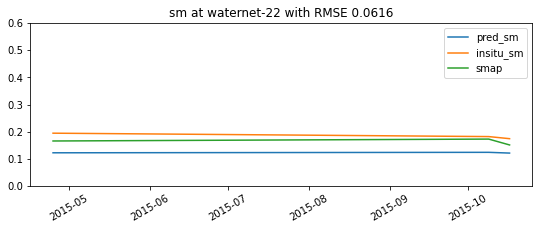

(5, 9)
0.10458423999826316


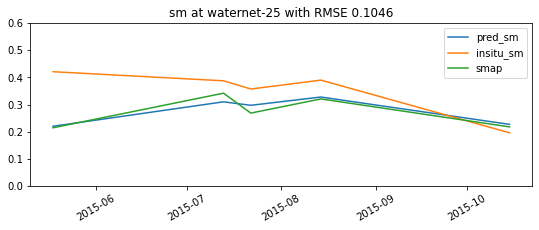

(2, 9)
0.044211628868052896


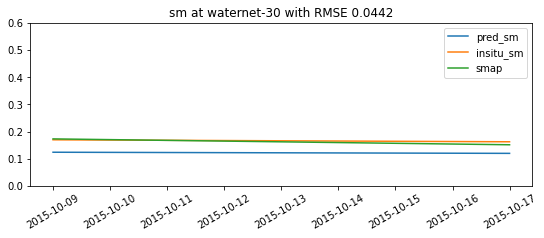

(3, 9)
0.07946679862058187


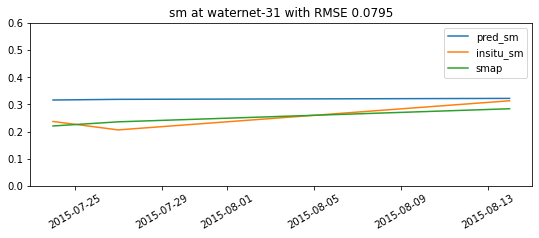

(9, 9)
0.04559065294433606


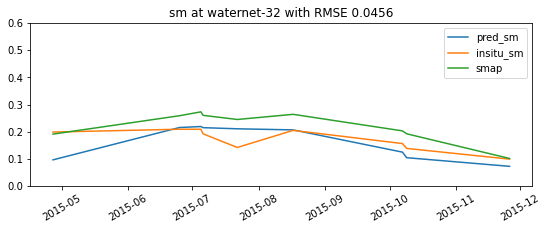

(3, 9)
0.12669879902480613


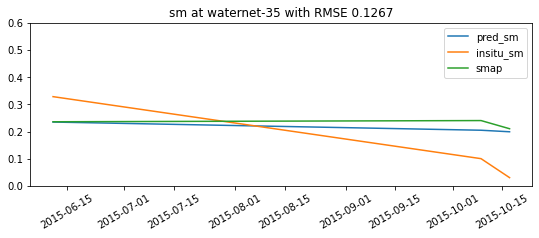

(2, 9)
0.01737198541526185


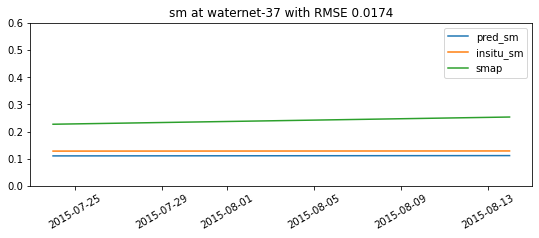

(4, 9)
0.08933231571013035


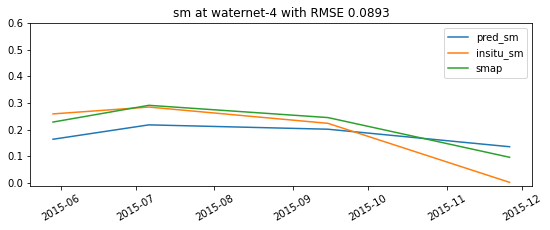

(3, 9)
0.18307822785048136


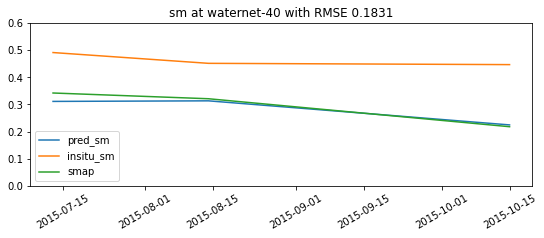

(5, 9)
0.042445609027637006


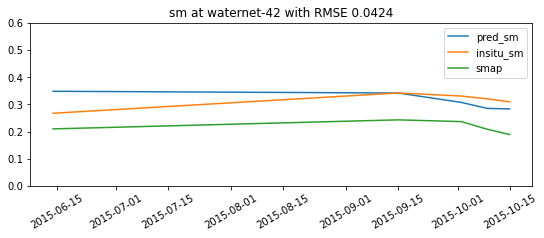

(6, 9)
0.13392752980386902


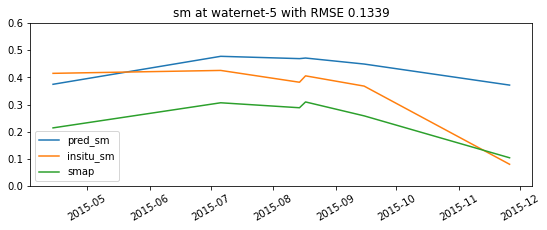

(2, 9)
0.08952378686892976


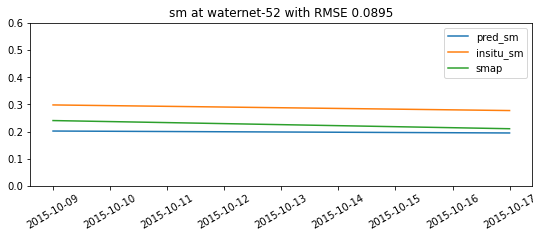

(4, 9)
0.2898195292605451


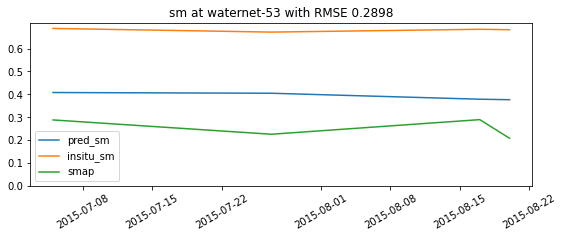

(10, 9)
0.05015563445047518


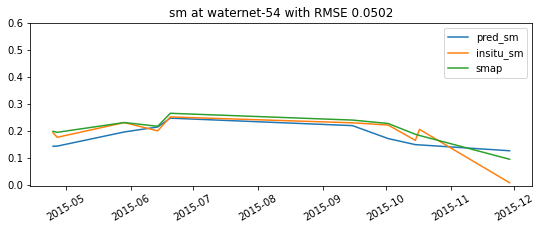

(6, 9)
0.06628793667858442


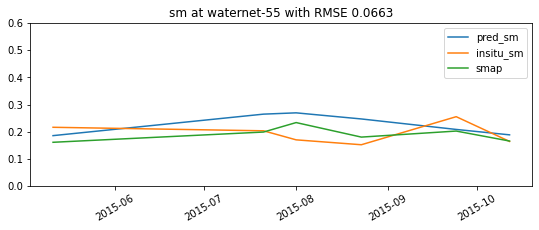

In [24]:
i = 0
for name, group in insitu_grouped:
    print(group.shape)
    print(insitu_rmse.iloc[i])
    plt.figure(figsize=(9,3))
    plt.plot(group['date'], group['pred_sm'], label='pred_sm')
    plt.plot(group['date'], group['insitu_sm'], label='insitu_sm')
    plt.plot(group['date'], group['smap'], label='smap')
    # 添加标题和标签
    plt.title('sm at waternet-'+ name + ' with RMSE ' + str(np.round(insitu_rmse.iloc[i], 4)))
    plt.legend()
    plt.xticks(rotation=30)
    plt.yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6])
    plt.savefig(os.path.join(config['model_save_dir'], 'sm at waternet-'+ name + 'with RMSE ' + str(np.round(insitu_rmse.iloc[i], 4)) + '.png'), dpi=300, bbox_inches='tight')
    plt.show()
    i+=1

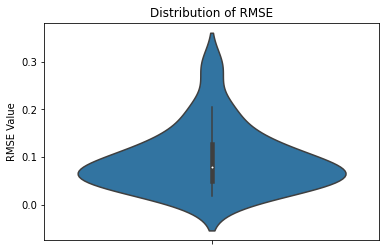

In [25]:
# 将数据转换为DataFrame格式
df_rmse = pd.DataFrame(insitu_rmse, columns=['RMSE'])

# 绘制小提琴图
sns.violinplot(y='RMSE', data=df_rmse, scale='count')
# sns.barplot(y='MSE', data=df)
# 添加标题和标签
plt.title('Distribution of RMSE')
# plt.xlabel('Index of Model')
plt.ylabel('RMSE Value')

# 显示图形
# plt.savefig(config['root'] + 'OUTPUT\\IMAGE\\DATAVISUALIZE\\CNN\\' + str(config['seed']) + '\\' + 'MSEDistribution.png', dpi=600, transparent=False)    
plt.show()

In [26]:
insitu_corr = insitu_grouped[['pred_sm', 'insitu_sm']].apply(calc_corr)
print(insitu_corr)

insituid
1          NaN
10   -0.495177
11   -0.377341
12   -0.891158
18    0.587349
2     1.000000
22    0.248949
25    0.400266
30    1.000000
31    0.758651
32    0.638958
35    0.996925
37    1.000000
4     0.801142
40    0.564774
42   -0.278339
5     0.607958
52    1.000000
53   -0.196330
54    0.667662
55   -0.328639
dtype: float64


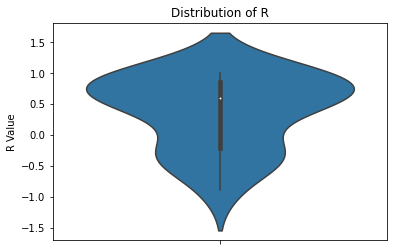

In [27]:
# 将数据转换为DataFrame格式
df_corr = pd.DataFrame(insitu_corr, columns=['R'])

# 绘制小提琴图
sns.violinplot(y='R', data=df_corr, scale='count')
# sns.barplot(y='MSE', data=df)
# 添加标题和标签
plt.title('Distribution of R')
# plt.xlabel('Index of Model')
plt.ylabel('R Value')

# 显示图形
# plt.savefig(config['root'] + 'OUTPUT\\IMAGE\\DATAVISUALIZE\\CNN\\' + str(config['seed']) + '\\' + 'MSEDistribution.png', dpi=600, transparent=False)    
plt.show()